In this notebook, I will demonstrate how to use the ORB (Oriented FAST and Rotated BRIEF) detector for keypoint detection and feature matching. As an example, I will use images of books from an online bookstore and a review blog post. The goal is to calculate a similarity score between these images to determine if they depict the same book.

Define some useful function to plot image without using OpenCV

In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%config InlineBackend.figure_format = 'retina'

In [2]:
def plot_one_image(path, title_text=None):
    plt.figure(figsize=(6, 6))
    image = mpimg.imread(path)
    plt.axis("off")
    if title_text:
        plt.title(title_text)
    plt.imshow(image)

Now we can plot images

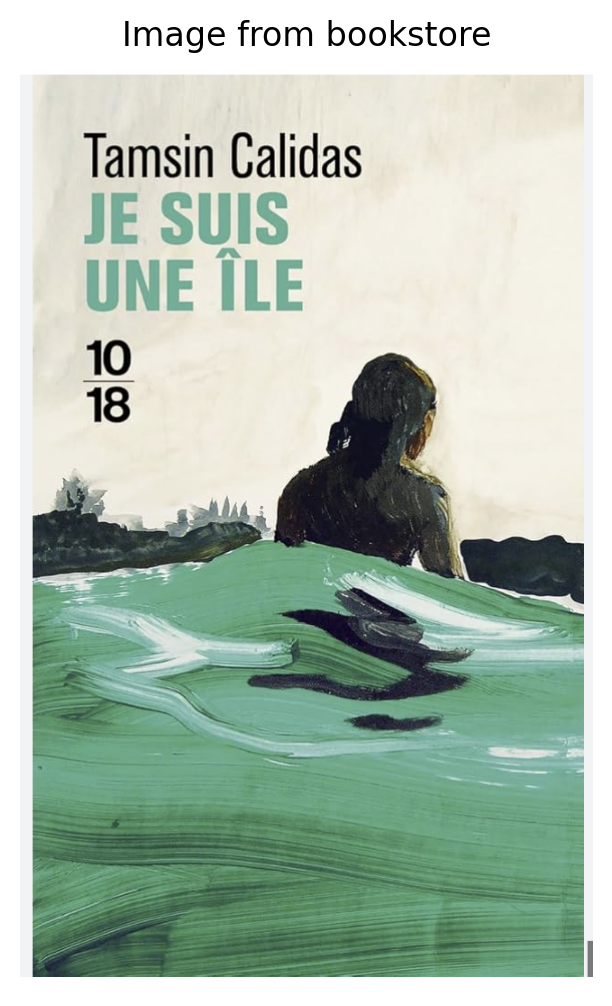

In [3]:
plot_one_image("images/book_1_orig.png", "Image from bookstore")

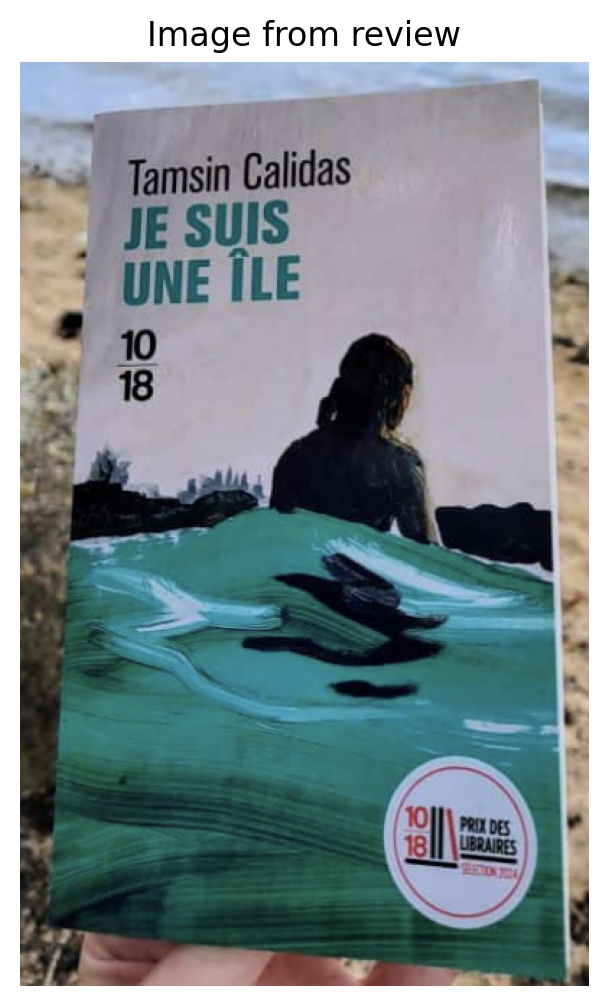

In [4]:
plot_one_image("images/book_1_photo_1.png", "Image from review")

We need to prepare images and get keypoints to calculate similarity score

#### Image preparation

In [5]:
import cv2

from utils import *

First, I will read the images using OpenCV (cv2) in grayscale mode.. For better matching, image shapes should be in a consistent scale. So I use function for resizing images to have maximum dimension as 256 pixels. I choose this number because in some my experiments it was optimum between accuracy and time of mathing. Larger images can improve accuracy but will increase the time required for matching.

In [6]:
book_image_1 = image_resize(cv2.imread("images/book_1_orig.png", 0))
book_image_2 = image_resize(cv2.imread("images/book_1_photo_1.png", 0))

In [7]:
book_image_1.shape, book_image_2.shape

((256, 158), (256, 157))

#### Extracting keypoints

```python 
def compute_orb(image: np.ndarray) -> Tuple[List[cv2.KeyPoint], np.ndarray]:
    """
    Compute ORB (Oriented FAST and Rotated BRIEF) keypoints and descriptors for a given image.

    Parameters:
    image (numpy.ndarray): The input grayscale image for which to compute the ORB keypoints and descriptors.

    Returns:
    - key_points (List[cv2.KeyPoint]): A list of detected keypoints.
    - descriptors (np.ndarray): An array of computed descriptors corresponding to the keypoints.
    """
    key_points, descriptors = orb.detectAndCompute(image, None)
    return key_points, descriptors
```

Then we need to extract keypoints from both images

In [8]:
book_image_1_points, book_image_1_desc = compute_orb(book_image_1)
book_image_2_points, book_image_2_desc = compute_orb(book_image_2)

#### Feature Matching

The `calculate_matches` function from `utils.py` uses the K-Nearest Neighbors (knnMatch) algorithm to find matching features between the two sets of keypoints.

```python
def calculate_matches(descriptor_1: np.ndarray, descriptor_2: np.ndarray) -> List[List[cv2.DMatch]]:
    """
    Calculate good matches between two sets of ORB descriptors using the BFMatcher with the KNN algorithm.

    Parameters:
    descriptor_1 (np.ndarray): Descriptors of the first image.
    descriptor_2 (np.ndarray): Descriptors of the second image.

    Returns:
    List[List[cv2.DMatch]]:
        A list of good matches. Each good match is a list containing a single DMatch object.
    """
    ratio = 0.89
    matches = bf.knnMatch(descriptor_1, descriptor_2, k=2)
    good_matches_1 = [[first] for first, second in matches if first.distance < second.distance * ratio]

    matches_2 = bf.knnMatch(descriptor_2, descriptor_1, k=2)
    good_matches_2 = [[first] for first, second in matches_2 if first.distance < second.distance * ratio]

    good_matches = [
        match1
        for match2 in good_matches_2
        for match1 in good_matches_1
        if match1[0].queryIdx == match2[0].trainIdx and match1[0].trainIdx == match2[0].queryIdx
    ]
    return good_matches
```

In [9]:
good_matches = calculate_matches(book_image_1_desc, book_image_2_desc)
print("Number of matched keypoint pairs:", len(good_matches))

Number of matched keypoint pairs: 35


#### Similarity Score Calculation

Now we can calculate similarity score. A higher score indicates a higher similarity between the images.

In [10]:
score = 100 * (len(good_matches) / max(len(book_image_1_points), len(book_image_2_points)))
score

29.411764705882355

#### Visualization

Using OpenCV, we can visualize the matched keypoint pairs on the images. This helps in understanding how well the features from the two images correspond to each other.

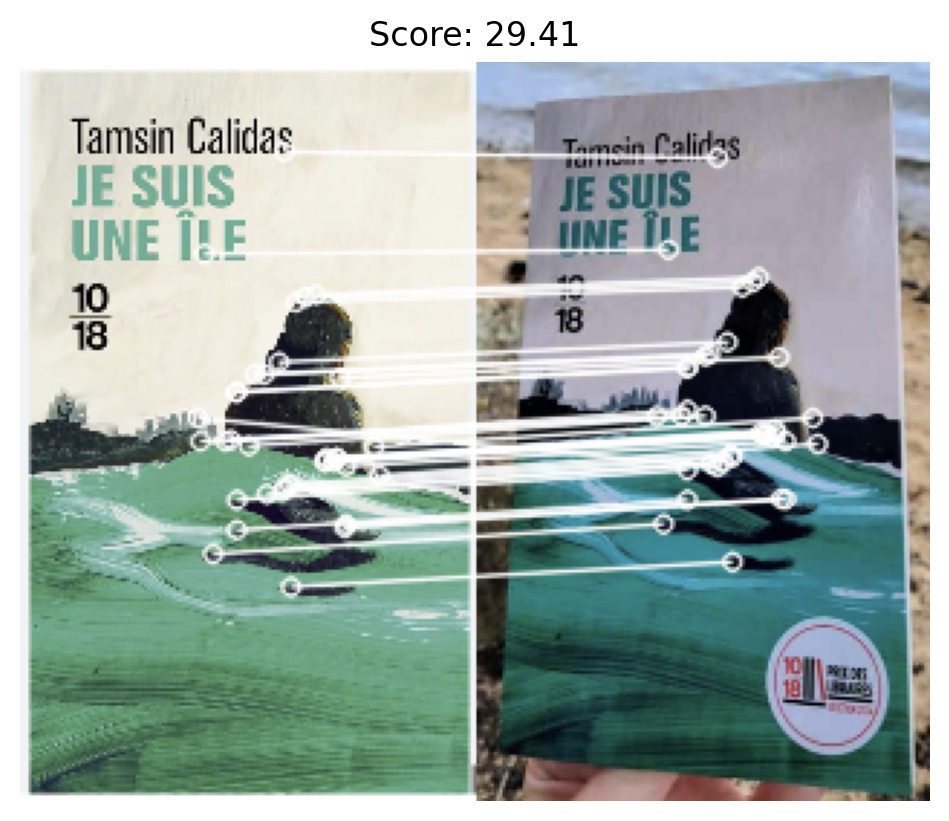

In [11]:
first_image = cv2.cvtColor(image_resize(cv2.imread("images/book_1_orig.png")), cv2.COLOR_BGR2RGB)
second_image = cv2.cvtColor(image_resize(cv2.imread("images/book_1_photo_1.png")), cv2.COLOR_BGR2RGB)

match_plot = cv2.drawMatchesKnn(
    first_image,
    book_image_1_points,
    second_image,
    book_image_2_points,
    good_matches,
    None,
    [255, 255, 255],
    flags=2,
)

plt.imshow(match_plot)
plt.title(f"Score: {round(score, 2)}")
plt.axis("off")
plt.show()

#### Function for Similarity Calculation and Visualization

Now I will introduce function that calculate score, plot images and matched pairs by paths to images

In [12]:
def calculate_similarity(path_1, path_2, show_plot=False):
    image_1 = image_resize(cv2.imread(path_1))
    image_2 = image_resize(cv2.imread(path_2))
    gray_image_1 = cv2.cvtColor(image_1, cv2.COLOR_BGR2GRAY)
    gray_image_2 = cv2.cvtColor(image_2, cv2.COLOR_BGR2GRAY)

    keypoints_1, descriptor_1 = compute_orb(gray_image_1)
    keypoints_2, descriptor_2 = compute_orb(gray_image_2)
    good_matches = calculate_matches(descriptor_1, descriptor_2)
    score = 100 * (len(good_matches) / max(len(keypoints_1), len(keypoints_2)))

    if show_plot:
        rgb_image_1 = cv2.cvtColor(image_1, cv2.COLOR_BGR2RGB)
        rgb_image_2 = cv2.cvtColor(image_2, cv2.COLOR_BGR2RGB)

        match_plot = cv2.drawMatchesKnn(
            rgb_image_1,
            keypoints_1,
            rgb_image_2,
            keypoints_2,
            good_matches,
            None,
            [255, 255, 255],
            flags=2,
        )

        plt.imshow(match_plot)
        plt.title(f"Score: {round(score, 2)}")
        plt.axis("off")
    return score

#### Examples

Let's see similarity score between images with different books

2.8169014084507045

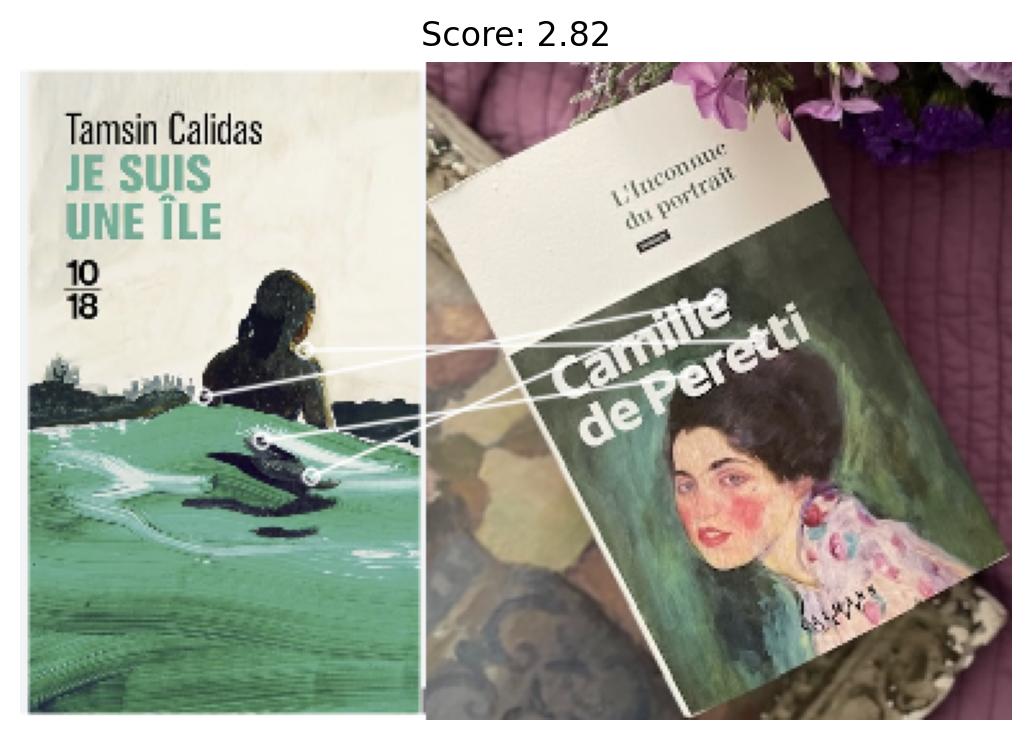

In [13]:
path_1 = "images/book_1_orig.png"
path_2 = "images/book_2_photo_1.jpeg"
calculate_similarity(path_1, path_2, show_plot=True)

As you can see current score is 2.82 while images with same book have 29.41 score

Below there will be other examples

32.800000000000004

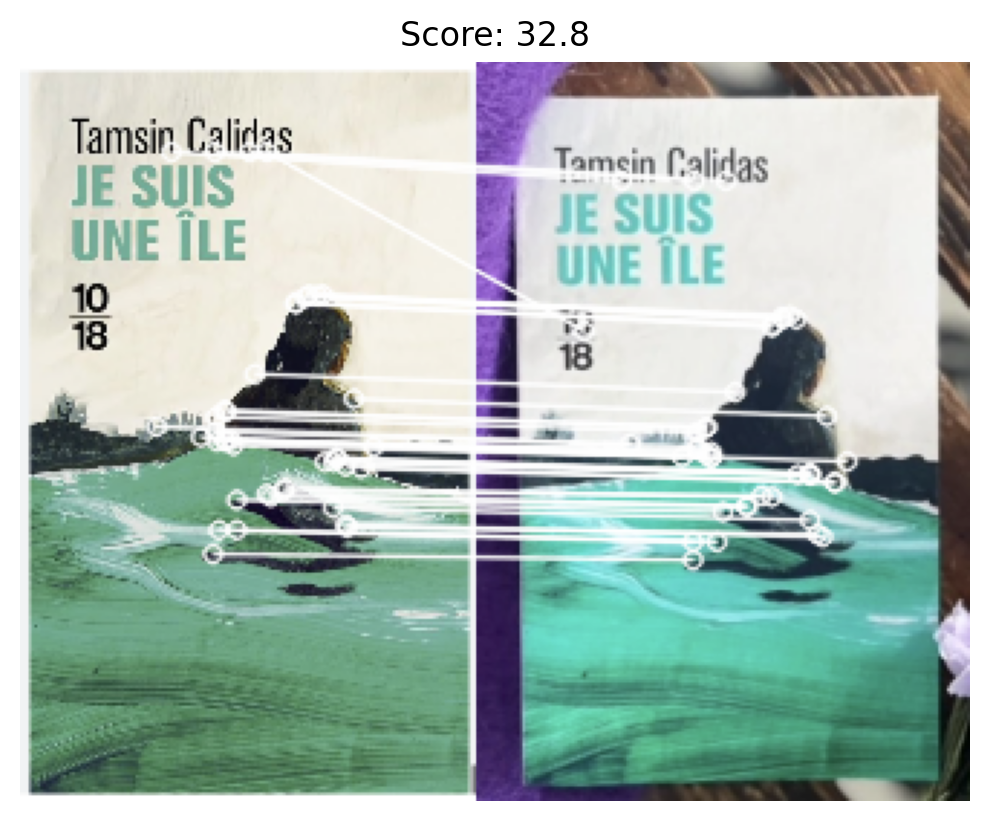

In [14]:
# same book
path_1 = "images/book_1_orig.png"
path_2 = "images/book_1_photo_2.png"
calculate_similarity(path_1, path_2, show_plot=True)

4.032258064516129

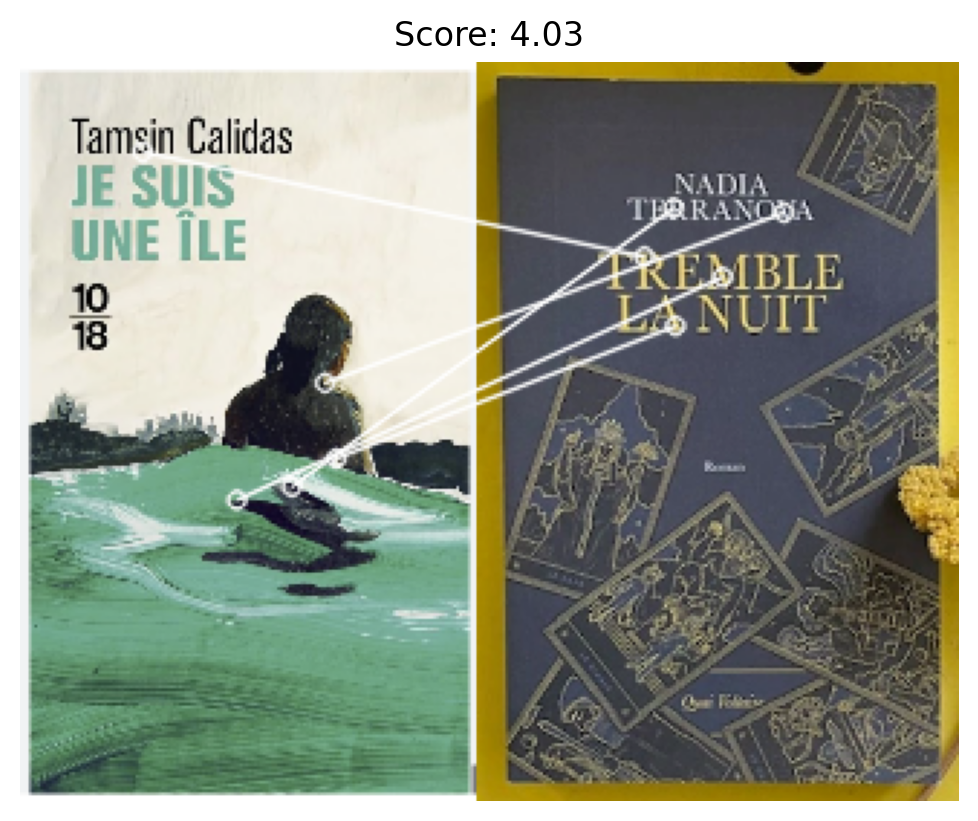

In [15]:
# different books
path_1 = "images/book_1_orig.png"
path_2 = "images/book_4_photo.png"
calculate_similarity(path_1, path_2, show_plot=True)

20.161290322580644

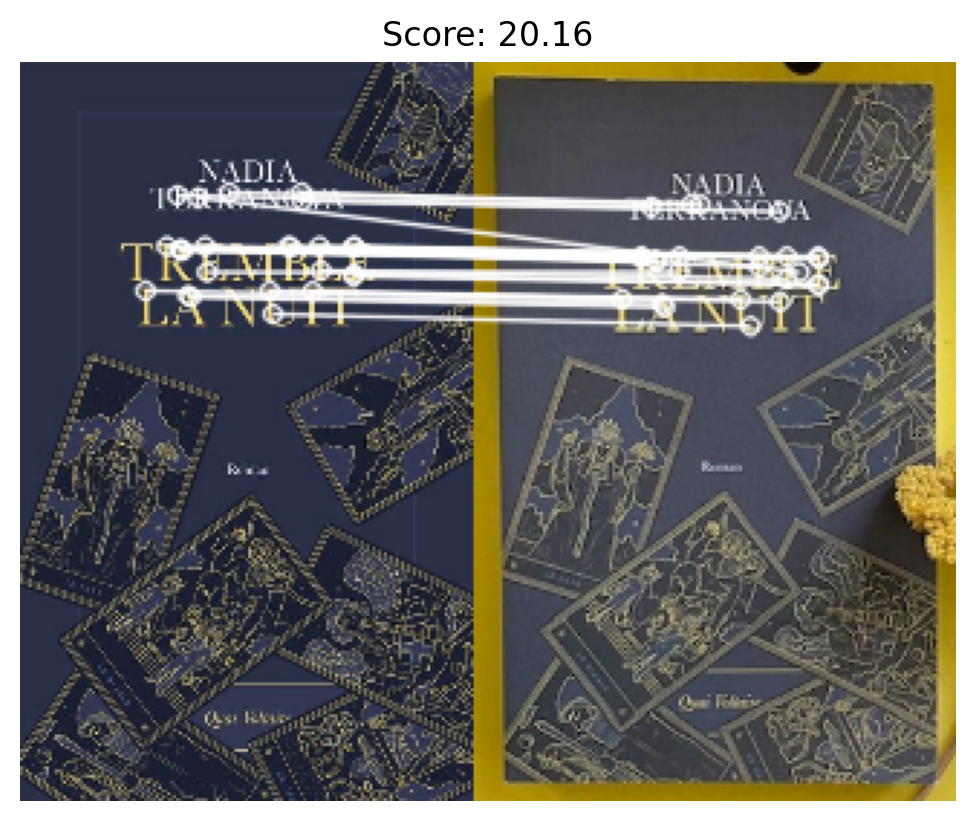

In [16]:
# same book
path_1 = "images/book_4_orig.jpg"
path_2 = "images/book_4_photo.png"
calculate_similarity(path_1, path_2, show_plot=True)